<a href="https://colab.research.google.com/github/qnrua0511/kaggle_study/blob/main/Natural_Language_Processing_with_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets

[진짜 재난 뉴스 판별기 만들기](https://www.kaggle.com/c/nlp-getting-started)



In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions list

ref                                                                                     deadline             category                reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2024                                      2024-11-10 23:59:00  Featured         1,100,000 Usd       1015           False  
https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use       2024-12-19 23:59:00  Featured            60,000 Usd         86           False  
https://www.kaggle.com/competitions/eedi-mining-misconceptions-in-mathematics           2024-12-12 23:59:00  Featured            55,000 Usd        303           False  
https://www.kaggle.com/competitions/rsna-2024-lumbar-spine-degenerative-classification  2024-10-08 23:59:00  Featured            50,000 Usd       1683     

In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 68.0MB/s]


In [14]:
import pandas as pd
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


5개의 변수
- id: 각 트위터 데이터의 식별자
- keyword : 해당 트윗의 특정 키워드
- location : 트위터가 작성된 장소
- text : 실제 트윗의 메시지
- target : 트위터가 실제로 재난이라면 1, 가짜라면 0이라고 표시

In [15]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


test에는 target 변수가 없음

## 탐색적 자료 분석

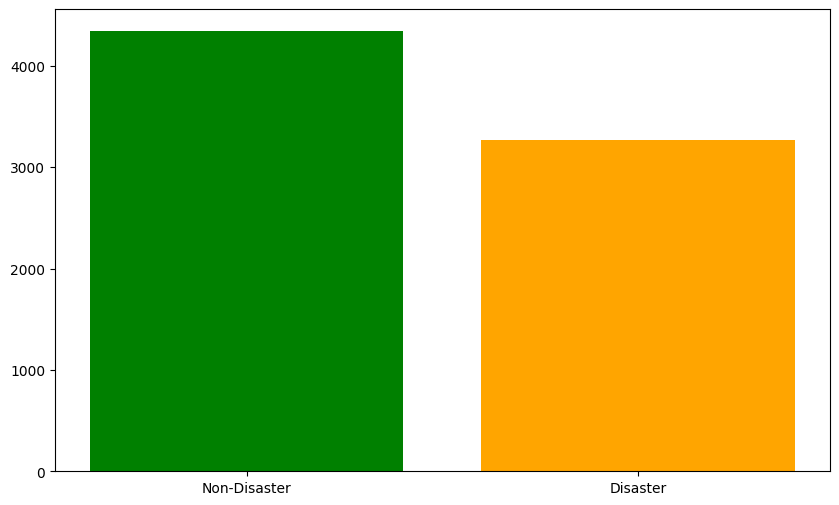

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

news_class=train['target'].value_counts()
labels=['Non-Disaster','Disaster']

fig,ax=plt.subplots(figsize=(10,6))
ax.bar(labels,news_class,color=['green','orange'])

fig.show()

Non-Disaster의 개수가 더 많을 것을 확인할 수 있음

보통 분류의 문제에서는 데이터가 불균형한 경우가 많음

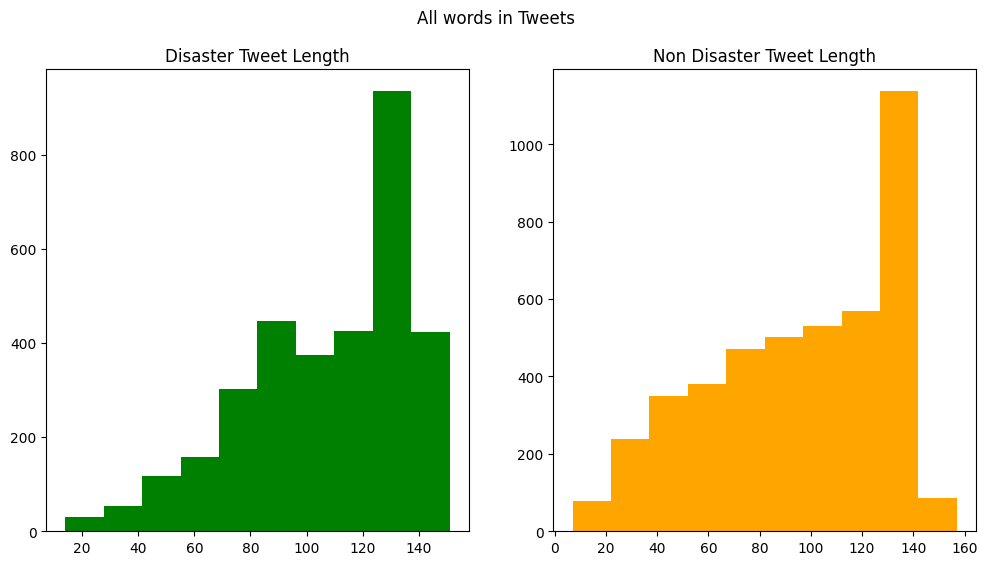

In [17]:
disaster_tweet_len=train[train['target']==1]['text'].str.len()
non_disaster_tweet_len=train[train['target']==0]['text'].str.len()

fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].hist(disaster_tweet_len,color='green')
ax[0].set_title("Disaster Tweet Length")

ax[1].hist(non_disaster_tweet_len,color='orange')
ax[1].set_title("Non Disaster Tweet Length")

fig.suptitle('All words in Tweets')
plt.show()

두 그래프 모두 비슷한 분포를 보임
- 특이점은 Non Disaster Tweet Length가 140이후 급격하게 떨어짐

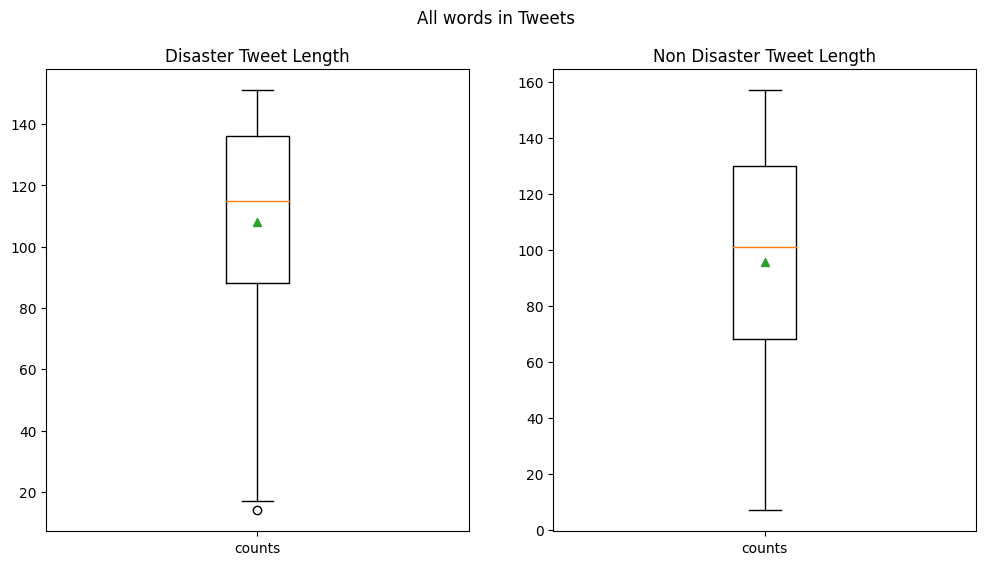

In [18]:
#박스 플롯을 통해 확인
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].boxplot(disaster_tweet_len,labels=['counts'],showmeans=True) #showmeans를 이용해 평균값을 삼각형으로 표시
ax[0].set_title('Disaster Tweet Length')
ax[1].boxplot(non_disaster_tweet_len,labels=['counts'],showmeans=True)
ax[1].set_title('Non Disaster Tweet Length')
fig.suptitle('All words in Tweets')
plt.show()

두 데이터 모두 중간값보다는 작은 값을 나타내는 것을 확인할 수 있음

전반적으로 Disaster가 Non Disaster보다 글자가 많을 것을 확인할 수 있음

이상치 데이터도 확인이 가능함

In [19]:
#통계값 확인
import numpy as np
disaster_tweet_len=train[train['target']==1]['text'].str.len()
non_distater_tweet_len=train[train['target']==0]['text'].str.len()

print('Max Length of Disaser Tweet: {}'.format(np.max(disaster_tweet_len)))
print('Min Length of Disaster Tweet: {}'.format(np.min(disaster_tweet_len)))
print('Mean Length of Disaster Tweet: {}'.format(np.mean(disaster_tweet_len)))
print('Median Length of Disaster Tweet: {}'.format(np.median(disaster_tweet_len)))

print('Max Length of Non Disaser Tweet: {}'.format(np.max(non_disaster_tweet_len)))
print('Min Length of Non Disaster Tweet: {}'.format(np.min(non_disaster_tweet_len)))
print('Mean Length of Non Disaster Tweet: {}'.format(np.mean(non_disaster_tweet_len)))
print('Median Length of Non Disaster Tweet: {}'.format(np.median(non_disaster_tweet_len)))

Max Length of Disaser Tweet: 151
Min Length of Disaster Tweet: 14
Mean Length of Disaster Tweet: 108.11342097217977
Median Length of Disaster Tweet: 115.0
Max Length of Non Disaser Tweet: 157
Min Length of Non Disaster Tweet: 7
Mean Length of Non Disaster Tweet: 95.70681713496084
Median Length of Non Disaster Tweet: 101.0


In [20]:
!pip install wordcloud

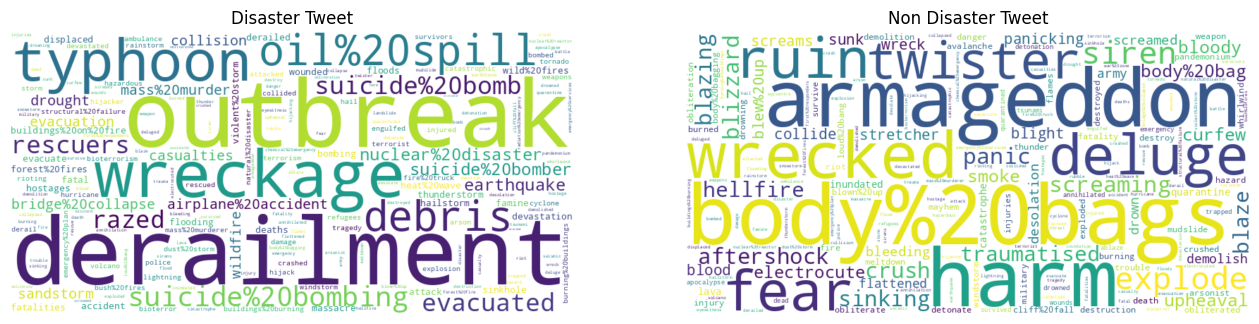

In [21]:
#워드클라우드를 통해 빈도수 확인
#STOPWORDS는 영어의 불용어처리를 도와주는 모듈
from wordcloud import WordCloud, STOPWORDS

disaster_tweet_keywords = dict(train[train['target']==1]['keyword'].value_counts())
non_disaster_tweet_keywords=dict(train[train['target']==0]['keyword'].value_counts())

stopwords=set(STOPWORDS)
disaster_wordcloud=WordCloud(stopwords=stopwords,width=800,height=400,background_color='white').generate_from_frequencies(disaster_tweet_keywords)
non_disaster_wordcloud=WordCloud(stopwords=stopwords,width=800,height=400,background_color='white').generate_from_frequencies(non_disaster_tweet_keywords)

fig,ax=plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(disaster_wordcloud,interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Disaster Tweet')
ax[1].imshow(non_disaster_wordcloud,interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Non Disaster Tweet')
fig.show()

Disaster은 Typhon(태풍), Wreckage(난파), Outbreak(어떤사건의 발생), Derailment(탈선) 등 명사로 설명

Non Disaster은 명사보다는 주로 형용사나 동사가 사용됨

## 피처 엔지니어링

텍스트는 수치형 데이터가 나오지 않을 뿐만 아니라 일반적인 정형 데이터에서 나오는 범주형 데이터와도 다르다

텍스트만을 대상으로 해서 사전에 손질해야 할 전처리 작업이 많음

### 결측치 확인

In [22]:
import pandas as pd
def check_na(data):
  isnull_na=(data.isnull().sum()/len(data))*100
  data_na=isnull_na.drop(isnull_na[isnull_na==0].index).sort_values(ascending=False)
  missing_data=pd.DataFrame({'Missing Ratio':data_na,
                             'Data Type':data.dtypes[data_na.index]})
  print("결측치 데이터 칼럼과 건수:\n",missing_data)

check_na(train)
check_na(test)

결측치 데이터 칼럼과 건수:
           Missing Ratio Data Type
location      33.272035    object
keyword        0.801261    object
결측치 데이터 칼럼과 건수:
           Missing Ratio Data Type
location      33.864542    object
keyword        0.796813    object


독립변수로 사용할 text 변수에 결측치가 없음을 확인할 수 있음
- 나머지 변수는 모두 제거
- test_id만 따로 추출해 저장

In [23]:
test_id=test['id']
for datas in [train,test]:
  datas=datas.drop(['id','keyword','location'],axis=1,inplace=True)

train.shape,test.shape

((7613, 2), (3263, 1))

### 텍스트 전처리 함수 만들기

이모티콘, 해쉬태그 등을 제거해야함

전처리 함수의 내부 구성
- 먼저 URL에 해당하는 문자들을 삭제
- html태그에 해당하는 문자들을 삭제
- 이모티콘들을 삭제
- 영어가 아닌 특수 문자를 공백으로 바꿈
- 구두점과 같은 기호들을 삭제
- 영어의 경우 대소문자가 존재하는데, 대소문자를 소문자로 변환
- 마지막으로 불용어를 제거

텍스트 마이닝은 텍스트 전처리 함수에 얼마나 정성을 들이느냐에 따라 성능이 좌우될 만큼 중요한 부분임

In [25]:
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def data_cleansing(text, remove_stopwords=False):
  #remove url
  url=re.compile(r'https?://\S+|www\.\S+')
  cleaned_text=url.sub(r'',text)

  #remove html
  html=re.compile(r'<.*?>')
  cleaned_text=html.sub(r'',cleaned_text)

  #remobe emoji
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

  cleaned_text=emoji_pattern.sub(r'',cleaned_text)

  #Special Letters to empty space
  cleaned_text=re.sub("[^a-zA-Z]","",cleaned_text)

  #Remove Punctuation
  table=str.maketrans('','',string.punctuation)
  cleaned_text=cleaned_text.translate(table)

  #Lowercase
  cleaned_text=cleaned_text.lower().split()

  if remove_stopwords:
    stops=set(stopwords.words("english"))
    cleaned_text=[word for word in cleaned_text if not word in stops]
    clean_review=' '.join(cleaned_text)
  else:
    clean_review=' '.join(cleaned_text)
  return clean_review

clean_train_reviews=[]
for datas in [train,test]:
  datas['cleaned_text']=datas['text'].apply(lambda x: data_cleansing(x,remove_stopwords=True))

train.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,target,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,ourdeedsarethereasonofthisearthquakemayallahfo...
1,Forest fire near La Ronge Sask. Canada,1,forestfirenearlarongesaskcanada
2,All residents asked to 'shelter in place' are ...,1,allresidentsaskedtoshelterinplacearebeingnotif...
3,"13,000 people receive #wildfires evacuation or...",1,peoplereceivewildfiresevacuationordersincalifo...
4,Just got sent this photo from Ruby #Alaska as ...,1,justgotsentthisphotofromrubyalaskaassmokefromw...


텍스트 마이닝을 하려면 텍스트 정보를 단위별로 나누어야함 이 절차를 Tokenize라고 부름

파이썬에서 활용하는 대표적인 영어 라이브러리는 NLTK(Natural Language Tool-kit)와 Spacy가 가장 많이 활용됨

정규 표현식 (re)
- ^ : 문자열의 시작
- $ : 문자열의 끝
- \* : 문자열의 반복(0회 이상)
- \+ : 문자열의 반복(1회 이상)
- [a-zA-Z] : 알파벳 모두
- [0-9] : 숫자
- [abc] : a,b,c 중 한 개의 문자와 일치

### Scikit-Learn 라이브러리를 활용한 특징 추출

CountVectorizer, TfdfVectorizer 크게 두 가지 방식이 있음
- TfdfVectorizer가 가장 일반적으로 사용함

CountVectorizer
- 각각의 텍스트 데이터를 분할해 단순하게 몇 번 나왔는지 숫자를 세는 개념

In [27]:
#예제
from sklearn.feature_extraction.text import CountVectorizer
corpus=['As you know, I want to be with you']
vector=CountVectorizer()
print(vector.fit_transform(corpus).toarray())
print(vector.vocabulary_)

[[1 1 1 1 1 1 2]]
{'as': 0, 'you': 6, 'know': 2, 'want': 4, 'to': 3, 'be': 1, 'with': 5}


'you'의 array와 인덱스가 다른 것을 보아 your가 두 번 나타난다는 것을 확인할 수 있음

In [28]:
#예제
#예제
from sklearn.feature_extraction.text import CountVectorizer
corpus=['As you know, I want to be with you',
        'Thank you, but I cannot be with you']
vector=CountVectorizer()
print(vector.fit_transform(corpus).toarray())
print(vector.vocabulary_)

[[1 1 0 0 1 0 1 1 1 2]
 [0 1 1 1 0 1 0 0 1 2]]
{'as': 0, 'you': 9, 'know': 4, 'want': 7, 'to': 6, 'be': 1, 'with': 8, 'thank': 5, 'but': 2, 'cannot': 3}


횟수만으로 한다면 I, you, to 같은 단어가 중요한 단어로 인식될 수 있음

TfdfVectorizer
- 단어의 빈도와 역 문장 빈도를 사용해서 문장 내의 각 단어마다 가중치를 부여하는 것을 말함

In [31]:
#예제
from sklearn.feature_extraction.text import TfidfVectorizer
corpus=['Can I have lunch with you?',
        'No, I cannot have it with you.',
        'Beacause, I need to study later']
tfidfv=TfidfVectorizer().fit(corpus)
print(np.round(tfidfv.transform(corpus).toarray(),2))
print(tfidfv.vocabulary_)

[[0.   0.52 0.   0.39 0.   0.   0.52 0.   0.   0.   0.   0.39 0.39]
 [0.   0.   0.46 0.35 0.46 0.   0.   0.   0.46 0.   0.   0.35 0.35]
 [0.45 0.   0.   0.   0.   0.45 0.   0.45 0.   0.45 0.45 0.   0.  ]]
{'can': 1, 'have': 3, 'lunch': 6, 'with': 11, 'you': 12, 'no': 8, 'cannot': 2, 'it': 4, 'beacause': 0, 'need': 7, 'to': 10, 'study': 9, 'later': 5}


can 과 lunch가 0.52로 가장 높음

have, with, you가 0.35 로 가장 낮음

이는 첫 문장에서도 나타나기 때문

하지만, 단점은 희소 행렬의 발생으로 인한 저장 공간 및 머신러닝 연산 학습 시의 메모리 낭비 등이 거론됨

In [34]:
vectorizer=TfidfVectorizer(min_df=0.0,analyzer='char',sublinear_tf=True,ngram_range=(1,3),max_features=10000)
X=vectorizer.fit_transform(train['cleaned_text']).todense()
y=train['target'].values
print(X.shape)
print(y.shape)

(7613, 10000)
(7613,)


7613은 학습 데이터, 10000은 현재 데이터에 사용된 전체 단어의 개수

## 머신러닝 모형 학습 및 평가

### 머신러닝 모형 학습

In [40]:
#훈련데이터와 검증데이터로 분류
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.3,random_state=0)
X_train.shape,X_valid.shape,y_train.shape,y_valid.shape

((5329, 10000), (2284, 10000), (5329,), (2284,))

In [44]:
#로지스틱 회귀 모델을 적용해 모형 학습
from sklearn.linear_model import LogisticRegression
# lgs=LogisticRegression(class_weight='balanced')
# lgs.fit(X_train,y_train)

import numpy as np

# X_train과 y_train을 np.array로 변환
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

# 로지스틱 회귀 모델 학습
lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [46]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

X_testset=vectorizer.transform(test['cleaned_text']).toarray()
print("The Shape of Test Dataset:",X_testset.shape)

y_test_pred=lgs.predict(X_testset)
print('The Predict Value:',y_test_pred)
y_test_pred=np.where(y_test_pred>=0.5,1,0)
print("The Predict Class:",y_test_pred)

submission_file=pd.DataFrame({'id':test_id,'target':y_test_pred})
print(submission_file.head())

submission_file.to_csv('submission_lgs_20210210.csv',index=False)

The Shape of Test Dataset: (3263, 10000)
The Predict Value: [1 0 1 ... 1 1 1]
The Predict Class: [1 0 1 ... 1 1 1]
   id  target
0   0       1
1   2       0
2   3       1
3   9       1
4  11       1


### 머신러닝 모형의 평가

평가지표
- 정확도
- 정밀도
- 재현율
- F1 Score
- Auc or Roc

혼동 행렬
- 이진 분류에서 성능 지표로 활용됨
- TP: 예측이 True, 실제 True
- TN: 예측이 False, 실제 False
- FP: 예측이 True, 실제 False
- FN: 예측이 False, 실제 True
